#### Imports

In [1]:
!pip install transformers
!pip install scikit-learn
!pip install datasets
!pip install torch
!pip install accelerate -U

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install pip install confplot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [3]:
%reload_ext autoreload
%autoreload 2

import os
import json
import time
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pylab as plt

from datasets import load_metric, Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizerFast, DataCollatorWithPadding, pipeline
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification

/Users/anu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Load dataframe

In [4]:
df=pd.DataFrame(columns=['DishName','Ingredients','Description','SpiceLevel','CookingMethod','PrepTime','HasAllergens','Cuisine','DietaryPreference','Protein-Rich','Pregnancy-Safe','Diabetic-Friendly'])
df

,DishName,Ingredients,Description,SpiceLevel,CookingMethod,PrepTime,HasAllergens,Cuisine,DietaryPreference,Protein-Rich,Pregnancy-Safe,Diabetic-Friendly


In [5]:
def process_json(filename):
    row={}
    path='FoodData/'+filename
    with open(path,'r') as f:
        dish_det=json.load(f)
        
        row['DishName']=os.path.splitext(filename)[0]
        row['Ingredients']=[i.strip() for i in dish_det['InputCols']['List of Main Ingredients'].split(",")]
        row['Description']=dish_det['InputCols']['Description']
        row['SpiceLevel']=dish_det['InputCols']['Spice Level']
        row['CookingMethod']=dish_det['InputCols']['Cooking Method']
        row['PrepTime']=dish_det['InputCols']['Preparation Time']
        row['HasAllergens']=dish_det['InputCols']['Contains Allergens']
        row['Cuisine']=dish_det['OutputCols']['Cuisine Type']
        row['DietaryPreference']=dish_det['OutputCols']['Dietary Preference']
        row['Protein-Rich']=dish_det['OutputCols']['Protein Rich']
        row['Pregnancy-Safe']=dish_det['OutputCols']['Pregnancy Safe']
        row['Diabetic-Friendly']=dish_det['OutputCols']['Diabetic Friendly']

    return row

In [6]:
a=[]
directory_path = '/Users/anu/Documents/NLP_Project_Food/FoodData/'
for filename in os.listdir(directory_path):
    name , file_extension = os.path.splitext(filename)
    
    if file_extension.lower()=='.json' and os.path.isfile(os.path.join(directory_path, filename)):
        a.append(name)

In [7]:
len(a)

409

In [8]:
for dish in tqdm(a,desc='processing',unit='item'):
    df.loc[len(df)]=process_json(dish+'.json')

processing:   0%|          | 0/409 [00:00<?, ?item/s]

In [9]:
df

,DishName,Ingredients,Description,SpiceLevel,CookingMethod,PrepTime,HasAllergens,Cuisine,DietaryPreference,Protein-Rich,Pregnancy-Safe,Diabetic-Friendly
0,Ven Pongal,"[Rice, Lentils, Ghee, Cumin seeds, Black peppe...",Ven Pongal is a traditional South Indian break...,3,Boiling and tempering,40,False,South Indian,Veg,True,True,True
1,Tom Yum Soup,"[lemongrass, galangal, kaffir lime leaves, chi...",Tom Yum Soup is a bold and aromatic Thai soup ...,8,Boiling,30,False,Thai,Non-Veg,True,True,False
2,Inji Puli,"[Tamarind, Ginger, Jaggery, Red Chili, Mustard...",Inji Puli is a traditional South Indian dish f...,6,Stovetop,30,False,South Indian,Veg,False,True,False
3,Pancakes,"[Flour, Milk, Eggs, Baking Powder, Sugar, Salt]",Pancakes are a popular breakfast dish made fro...,2,Griddling,20,True,American,Vegetarian,False,True,False
4,Ossobuco alla Milanese,"[Veal shanks, Onion, Carrot, Celery, White win...",Ossobuco alla Milanese is a traditional Italia...,3,Braising,180,False,Italian,Non-Veg,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
404,Kara Kuzhambu,"[Tamarind, vegetables (like brinjal, drumstick...",Kara Kuzhambu is a spicy and tangy South India...,8,Stovetop cooking,40,False,South Indian,Veg,False,True,True
405,Tortellini in Brodo,"[Pasta, Meat, Broth, Parmesan Cheese]",Tortellini in Brodo is a classic Italian dish ...,2,Boiling,30,True,Italian,Non-Veg,True,False,False
406,Egg Masala,"[Eggs, tomatoes, onions, garlic, ginger, spices]",Egg Masala is a flavorful Indian dish made wit...,7,Stovetop,30,False,Indian,Non-Veg,True,True,False
407,French Toast,"[Bread, Eggs, Milk, Cinnamon, Vanilla extract]",French toast is a classic breakfast dish made ...,2,Pan-Frying,20,True,French,Non-Veg,False,True,False


### EDA

In [10]:
df.dtypes

DishName             object
Ingredients          object
Description          object
SpiceLevel            int64
CookingMethod        object
PrepTime              int64
HasAllergens           bool
Cuisine              object
DietaryPreference    object
Protein-Rich           bool
Pregnancy-Safe         bool
Diabetic-Friendly      bool
dtype: object

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 409 entries, 0 to 408
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DishName           409 non-null    object
 1   Ingredients        409 non-null    object
 2   Description        409 non-null    object
 3   SpiceLevel         409 non-null    int64 
 4   CookingMethod      409 non-null    object
 5   PrepTime           409 non-null    int64 
 6   HasAllergens       409 non-null    bool  
 7   Cuisine            409 non-null    object
 8   DietaryPreference  409 non-null    object
 9   Protein-Rich       409 non-null    bool  
 10  Pregnancy-Safe     409 non-null    bool  
 11  Diabetic-Friendly  409 non-null    bool  
dtypes: bool(4), int64(2), object(6)
memory usage: 30.4+ KB


In [12]:
df.describe()

,SpiceLevel,PrepTime
count,409.000000,409.000000
mean,4.425428,51.161369
std,2.289134,47.921846
min,0.000000,0.000000
25%,2.000000,30.000000
50%,4.000000,40.000000
75%,7.000000,60.000000
max,8.000000,480.000000


SpiceLevel
2    88
7    75
3    66
5    44
8    41
4    35
6    34
1    19
0     7
Name: count, dtype: int64


<Axes: xlabel='SpiceLevel', ylabel='count'>

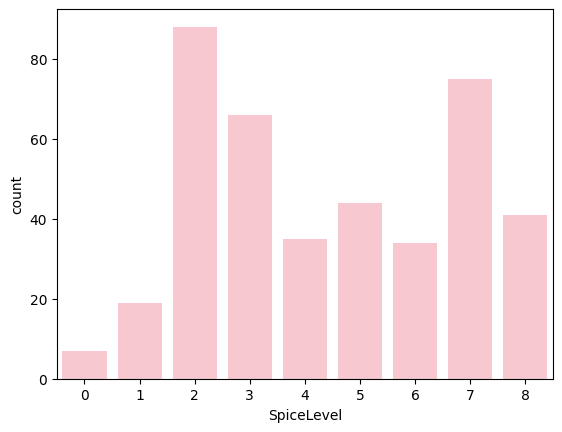

In [13]:
print(df['SpiceLevel'].value_counts())
sns.countplot(df,x='SpiceLevel',color='pink')

<Axes: xlabel='HasAllergens', ylabel='count'>

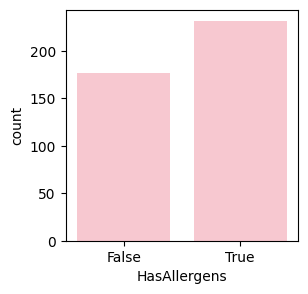

In [14]:
plt.figure(figsize=(3,3))
df['HasAllergens'].value_counts()
sns.countplot(data=df,x='HasAllergens',color='pink')

In [15]:
df['Cuisine'].value_counts()

Cuisine
Indian                          141
South Indian                     66
American                         42
Italian                          35
Chinese                          26
South Asian                      19
Dessert                           8
Asian                             7
French                            7
Japanese                          5
Mexican                           4
Mediterranean                     4
Chinese-American                  4
Thai                              3
Latin American                    3
Italian-American                  3
Korean                            2
Middle Eastern                    2
Pakistani                         2
Indo-Chinese                      2
Maharashtrian                     2
British                           2
East Asian                        1
Multi-Cuisine                     1
Plant-based                       1
Beverage                          1
Vietnamese                        1
Punjabi             

In [16]:
cuisine_mapping={'South Asian': 'Asian', 'Plant-based':'Asian', 'Japanese': 'Asian', 'Hong Kong':'Asian', 'Thai': 'Asian', 'Korean': 'Asian','Pakistani': 'Asian', 'East Asian': 'Asian', 'Vegetarian': 'Asian' , 'Vietnamese': 'Asian', 'Parsi': 'Asian', 'Mexican': 'American','Mediterranean': 'Continental', 'Hungarian': 'Continental', 'Latin American': 'Continental', 'Dessert' : 'Continental', 'British' : 'Continental', 'Russian' : 'Continental', 'Middle Eastern': 'Continental' , 'Spanish' : 'Continental', 'Beverage': 'Continental' , 'Turkish': 'Continental' , 'Middle Eastern/North African': 'Continental', 'Irish': 'Continental', 'Greek': 'Continental', 'Caribbean': 'Continental', 'Louisiana Creole': 'Continental',
'Chinese-American': 'Fusion', 'French':'Continental', 'Fusion':'Continental','Italian-American': 'Fusion', 'International':'Continental','Multi-Cuisine': 'Fusion', 'Modern': 'Fusion', 'Mixed': 'Fusion' , 'Indo-Chinese' : 'Fusion', 'Maharashtrian': 'Indian' , 'North Indian': 'Indian', 'Kashmiri': 'Indian' , 'Punjabi' : 'Indian', }

In [17]:
df['Cuisine'].replace(cuisine_mapping,inplace=True)
df['Cuisine'].value_counts()

Cuisine
Indian          145
South Indian     66
American         46
Asian            43
Continental      36
Italian          35
Chinese          26
Fusion           12
Name: count, dtype: int64

<Axes: xlabel='Cuisine', ylabel='count'>

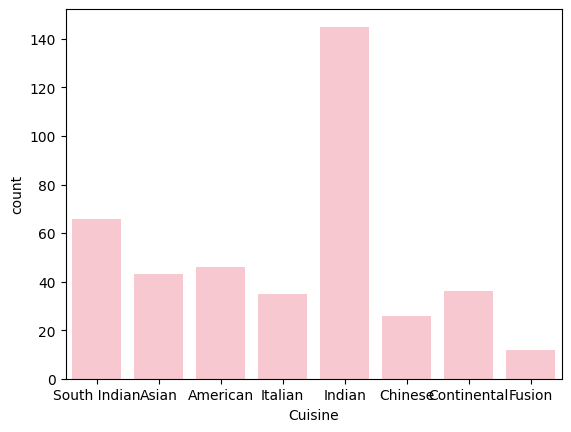

In [18]:
sns.countplot(x='Cuisine',data=df,color='pink')

In [19]:
df['DietaryPreference'].value_counts()

DietaryPreference
Non-Veg       206
Veg           123
Vegetarian     63
Vegan          17
Name: count, dtype: int64

<Axes: xlabel='DietaryPreference', ylabel='count'>

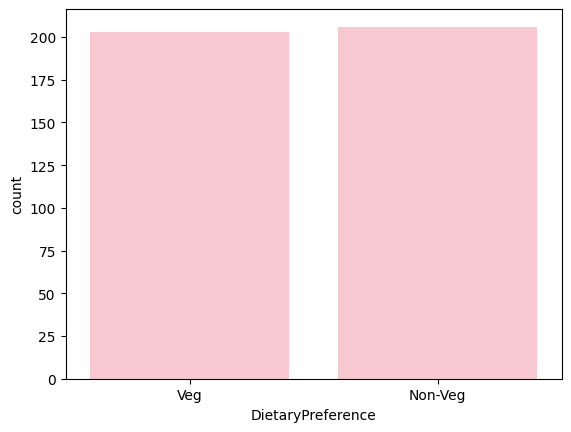

In [20]:
df['DietaryPreference'].replace({'Vegetarian':'Veg','Vegan':'Veg'},inplace=True)
sns.countplot(df,x='DietaryPreference',color='pink')

In [21]:
df['DietaryPreference'].value_counts()

DietaryPreference
Non-Veg    206
Veg        203
Name: count, dtype: int64

In [22]:
df['Diabetic-Friendly'].value_counts()

Diabetic-Friendly
False    290
True     119
Name: count, dtype: int64

In [23]:
df['Pregnancy-Safe'].value_counts()

Pregnancy-Safe
True     256
False    153
Name: count, dtype: int64

In [24]:
df['Protein-Rich'].value_counts()

Protein-Rich
True     249
False    160
Name: count, dtype: int64

### Train BERT classifier on dietary preference

In [25]:
utterances = df['Description'].to_list()
seq_labels = df["DietaryPreference"].to_list()
print(len(utterances), len(seq_labels))


409 409


In [26]:
unique_seq_labels = list(df["DietaryPreference"].unique())
print(unique_seq_labels)

['Veg', 'Non-Veg']


In [27]:
seq_id = [unique_seq_labels.index(l) for l in seq_labels]


In [28]:
from transformers import AutoTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

In [29]:
tokenized_utterances = []
attention_masks = []
for utt in tqdm(utterances) :
    try :
        it = tokenizer(utt, truncation=True, max_length=32)
        tokenized_utterances.append(it['input_ids'])
        attention_masks.append(it['attention_mask'])
    except :
        print(utt)

  0%|          | 0/409 [00:00<?, ?it/s]

In [30]:
myData = Dataset.from_dict(dict(utterance=utterances,
                                input_ids=tokenized_utterances,
                                attention_mask=attention_masks,
                                label_txt=seq_labels,
                                label=seq_id)
                          )
# column we want to stratify with respect to
stratify_column_name = "label"

# create class label column and stratify
np.random.seed(5)
myData= myData.class_encode_column(stratify_column_name).train_test_split(test_size=0.2, stratify_by_column=stratify_column_name)

Stringifying the column:   0%|          | 0/409 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/409 [00:00<?, ? examples/s]

In [31]:
myData

DatasetDict({
    train: Dataset({
        features: ['utterance', 'input_ids', 'attention_mask', 'label_txt', 'label'],
        num_rows: 327
    })
    test: Dataset({
        features: ['utterance', 'input_ids', 'attention_mask', 'label_txt', 'label'],
        num_rows: 82
    })
})

In [32]:
myData['train'][0]

{'utterance': 'Masoor Dal is a popular Indian lentil dish made with red lentils cooked with aromatic spices like turmeric, cumin, and garlic. It is a comforting, nutritious dish often served with rice or bread.',
 'input_ids': [101,
  7085,
  7301,
  1766,
  25938,
  1110,
  170,
  1927,
  1890,
  20283,
  2723,
  10478,
  1189,
  1114,
  1894,
  20283,
  8825,
  13446,
  1114,
  170,
  16341,
  25133,
  1176,
  189,
  2149,
  4027,
  1596,
  117,
  16040,
  1394,
  117,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'label_txt': 'Veg',
 'label': 0}

In [33]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [34]:
# Initialize the model using from_pretrained
seq_clf_mdl = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
seq_clf_mdl.config.id2label = {i: l for i, l in enumerate(unique_seq_labels)}


In [36]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


/var/folders/2p/d_5l4xlj7ygbv8ldw505sjnr0000gn/T/ipykernel_10422/754301748.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/Users/anu/Library/Python/3.9/lib/python/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [37]:
epochs = 30

training_args = TrainingArguments(
    output_dir="./new_distilbert_clf_dietary/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=1024,
    per_device_eval_batch_size=1024,
    load_best_model_at_end=True,
    logging_steps=1,
    log_level='info',
    evaluation_strategy='epoch',
    eval_steps=5000,
    save_strategy='epoch',
)

# Define the trainer:
trainer = Trainer(
    model=seq_clf_mdl,
    args=training_args,
    train_dataset=myData['train'],
    eval_dataset=myData['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)


/Users/anu/Library/Python/3.9/lib/python/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [38]:
trainer.evaluate()


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6942044496536255,
 'eval_accuracy': 0.5,
 'eval_runtime': 1.2403,
 'eval_samples_per_second': 66.115,
 'eval_steps_per_second': 0.806}

In [38]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 327
  Num Epochs = 30
  Instantaneous batch size per device = 1,024
  Total train batch size (w. parallel, distributed & accumulation) = 1,024
  Gradient Accumulation steps = 1
  Total optimization steps = 30
  Number of trainable parameters = 66,955,010


  0%|          | 0/30 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.6966, 'grad_norm': 0.33312034606933594, 'learning_rate': 4.8333333333333334e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-1
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-1/config.json


{'eval_loss': 0.6843011379241943, 'eval_accuracy': 0.5487804878048781, 'eval_runtime': 0.2126, 'eval_samples_per_second': 385.652, 'eval_steps_per_second': 4.703, 'epoch': 1.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-1/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.6868, 'grad_norm': 0.354769229888916, 'learning_rate': 4.666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-2
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-2/config.json


{'eval_loss': 0.6778129935264587, 'eval_accuracy': 0.6219512195121951, 'eval_runtime': 0.1039, 'eval_samples_per_second': 789.25, 'eval_steps_per_second': 9.625, 'epoch': 2.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-2/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.6798, 'grad_norm': 0.4912261366844177, 'learning_rate': 4.5e-05, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-3
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-3/config.json


{'eval_loss': 0.652193546295166, 'eval_accuracy': 0.7439024390243902, 'eval_runtime': 0.1087, 'eval_samples_per_second': 754.641, 'eval_steps_per_second': 9.203, 'epoch': 3.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-3/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.6588, 'grad_norm': 0.6021853685379028, 'learning_rate': 4.3333333333333334e-05, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-4
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-4/config.json


{'eval_loss': 0.6275544762611389, 'eval_accuracy': 0.6951219512195121, 'eval_runtime': 0.1009, 'eval_samples_per_second': 812.846, 'eval_steps_per_second': 9.913, 'epoch': 4.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-4/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.6352, 'grad_norm': 1.391676902770996, 'learning_rate': 4.166666666666667e-05, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-5
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-5/config.json


{'eval_loss': 0.6085324287414551, 'eval_accuracy': 0.7195121951219512, 'eval_runtime': 0.1132, 'eval_samples_per_second': 724.286, 'eval_steps_per_second': 8.833, 'epoch': 5.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-5/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.6114, 'grad_norm': 2.8053159713745117, 'learning_rate': 4e-05, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-6
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-6/config.json


{'eval_loss': 0.5688818693161011, 'eval_accuracy': 0.7439024390243902, 'eval_runtime': 0.1056, 'eval_samples_per_second': 776.229, 'eval_steps_per_second': 9.466, 'epoch': 6.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-6/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.5546, 'grad_norm': 2.1060116291046143, 'learning_rate': 3.8333333333333334e-05, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-7
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-7/config.json


{'eval_loss': 0.5875203013420105, 'eval_accuracy': 0.7317073170731707, 'eval_runtime': 0.1252, 'eval_samples_per_second': 654.857, 'eval_steps_per_second': 7.986, 'epoch': 7.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-7/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.5505, 'grad_norm': 5.850667476654053, 'learning_rate': 3.6666666666666666e-05, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-8
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-8/config.json


{'eval_loss': 0.569604754447937, 'eval_accuracy': 0.7317073170731707, 'eval_runtime': 0.1097, 'eval_samples_per_second': 747.329, 'eval_steps_per_second': 9.114, 'epoch': 8.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-8/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.5154, 'grad_norm': 5.29116153717041, 'learning_rate': 3.5e-05, 'epoch': 9.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-9
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-9/config.json


{'eval_loss': 0.5220125913619995, 'eval_accuracy': 0.7560975609756098, 'eval_runtime': 0.1054, 'eval_samples_per_second': 777.694, 'eval_steps_per_second': 9.484, 'epoch': 9.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-9/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.4527, 'grad_norm': 2.2148282527923584, 'learning_rate': 3.3333333333333335e-05, 'epoch': 10.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-10
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-10/config.json


{'eval_loss': 0.5122970342636108, 'eval_accuracy': 0.7682926829268293, 'eval_runtime': 0.1106, 'eval_samples_per_second': 741.077, 'eval_steps_per_second': 9.038, 'epoch': 10.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-10/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.4249, 'grad_norm': 3.7412097454071045, 'learning_rate': 3.1666666666666666e-05, 'epoch': 11.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-11
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-11/config.json


{'eval_loss': 0.521614134311676, 'eval_accuracy': 0.7682926829268293, 'eval_runtime': 0.1058, 'eval_samples_per_second': 774.982, 'eval_steps_per_second': 9.451, 'epoch': 11.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-11/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.3954, 'grad_norm': 1.3410881757736206, 'learning_rate': 3e-05, 'epoch': 12.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-12
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-12/config.json


{'eval_loss': 0.528638482093811, 'eval_accuracy': 0.7682926829268293, 'eval_runtime': 0.1052, 'eval_samples_per_second': 779.268, 'eval_steps_per_second': 9.503, 'epoch': 12.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-12/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.3452, 'grad_norm': 2.5122947692871094, 'learning_rate': 2.8333333333333335e-05, 'epoch': 13.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-13
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-13/config.json


{'eval_loss': 0.5152335166931152, 'eval_accuracy': 0.7804878048780488, 'eval_runtime': 0.1003, 'eval_samples_per_second': 817.831, 'eval_steps_per_second': 9.974, 'epoch': 13.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-13/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.317, 'grad_norm': 1.890784740447998, 'learning_rate': 2.6666666666666667e-05, 'epoch': 14.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-14
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-14/config.json


{'eval_loss': 0.5155175924301147, 'eval_accuracy': 0.7804878048780488, 'eval_runtime': 0.1034, 'eval_samples_per_second': 793.298, 'eval_steps_per_second': 9.674, 'epoch': 14.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-14/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.2809, 'grad_norm': 1.4019222259521484, 'learning_rate': 2.5e-05, 'epoch': 15.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-15
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-15/config.json


{'eval_loss': 0.5089586973190308, 'eval_accuracy': 0.7926829268292683, 'eval_runtime': 0.104, 'eval_samples_per_second': 788.676, 'eval_steps_per_second': 9.618, 'epoch': 15.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-15/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.2565, 'grad_norm': 2.6540651321411133, 'learning_rate': 2.3333333333333336e-05, 'epoch': 16.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-16
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-16/config.json


{'eval_loss': 0.5219717025756836, 'eval_accuracy': 0.7804878048780488, 'eval_runtime': 0.1058, 'eval_samples_per_second': 774.901, 'eval_steps_per_second': 9.45, 'epoch': 16.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-16/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.2168, 'grad_norm': 1.9873182773590088, 'learning_rate': 2.1666666666666667e-05, 'epoch': 17.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-17
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-17/config.json


{'eval_loss': 0.5189790725708008, 'eval_accuracy': 0.7926829268292683, 'eval_runtime': 0.0992, 'eval_samples_per_second': 826.261, 'eval_steps_per_second': 10.076, 'epoch': 17.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-17/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.2104, 'grad_norm': 1.1162402629852295, 'learning_rate': 2e-05, 'epoch': 18.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-18
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-18/config.json


{'eval_loss': 0.5118248462677002, 'eval_accuracy': 0.7926829268292683, 'eval_runtime': 0.1053, 'eval_samples_per_second': 778.469, 'eval_steps_per_second': 9.494, 'epoch': 18.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-18/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1792, 'grad_norm': 1.4998670816421509, 'learning_rate': 1.8333333333333333e-05, 'epoch': 19.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-19
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-19/config.json


{'eval_loss': 0.5225933790206909, 'eval_accuracy': 0.7926829268292683, 'eval_runtime': 0.1189, 'eval_samples_per_second': 689.736, 'eval_steps_per_second': 8.411, 'epoch': 19.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-19/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1727, 'grad_norm': 1.345758080482483, 'learning_rate': 1.6666666666666667e-05, 'epoch': 20.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-20
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-20/config.json


{'eval_loss': 0.5205591917037964, 'eval_accuracy': 0.8048780487804879, 'eval_runtime': 0.1043, 'eval_samples_per_second': 786.224, 'eval_steps_per_second': 9.588, 'epoch': 20.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-20/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1526, 'grad_norm': 0.9524264335632324, 'learning_rate': 1.5e-05, 'epoch': 21.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-21
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-21/config.json


{'eval_loss': 0.518901526927948, 'eval_accuracy': 0.8170731707317073, 'eval_runtime': 0.1086, 'eval_samples_per_second': 755.301, 'eval_steps_per_second': 9.211, 'epoch': 21.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-21/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1496, 'grad_norm': 2.3529555797576904, 'learning_rate': 1.3333333333333333e-05, 'epoch': 22.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-22
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-22/config.json


{'eval_loss': 0.5302168130874634, 'eval_accuracy': 0.8170731707317073, 'eval_runtime': 0.1152, 'eval_samples_per_second': 711.991, 'eval_steps_per_second': 8.683, 'epoch': 22.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-22/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1327, 'grad_norm': 1.3582220077514648, 'learning_rate': 1.1666666666666668e-05, 'epoch': 23.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-23
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-23/config.json


{'eval_loss': 0.5488225221633911, 'eval_accuracy': 0.7804878048780488, 'eval_runtime': 0.106, 'eval_samples_per_second': 773.737, 'eval_steps_per_second': 9.436, 'epoch': 23.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-23/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1205, 'grad_norm': 2.24552321434021, 'learning_rate': 1e-05, 'epoch': 24.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-24
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-24/config.json


{'eval_loss': 0.5532670021057129, 'eval_accuracy': 0.7804878048780488, 'eval_runtime': 0.1105, 'eval_samples_per_second': 741.759, 'eval_steps_per_second': 9.046, 'epoch': 24.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-24/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.128, 'grad_norm': 3.6739909648895264, 'learning_rate': 8.333333333333334e-06, 'epoch': 25.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-25
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-25/config.json


{'eval_loss': 0.5469937324523926, 'eval_accuracy': 0.8048780487804879, 'eval_runtime': 0.1059, 'eval_samples_per_second': 774.402, 'eval_steps_per_second': 9.444, 'epoch': 25.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-25/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1114, 'grad_norm': 2.4374146461486816, 'learning_rate': 6.666666666666667e-06, 'epoch': 26.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-26
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-26/config.json


{'eval_loss': 0.5382205247879028, 'eval_accuracy': 0.8170731707317073, 'eval_runtime': 0.1159, 'eval_samples_per_second': 707.672, 'eval_steps_per_second': 8.63, 'epoch': 26.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-26/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1047, 'grad_norm': 1.21234130859375, 'learning_rate': 5e-06, 'epoch': 27.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-27
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-27/config.json


{'eval_loss': 0.5366402268409729, 'eval_accuracy': 0.8170731707317073, 'eval_runtime': 0.1049, 'eval_samples_per_second': 781.579, 'eval_steps_per_second': 9.531, 'epoch': 27.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-27/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1011, 'grad_norm': 0.9242075681686401, 'learning_rate': 3.3333333333333333e-06, 'epoch': 28.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-28
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-28/config.json


{'eval_loss': 0.5373612642288208, 'eval_accuracy': 0.8170731707317073, 'eval_runtime': 0.1077, 'eval_samples_per_second': 761.338, 'eval_steps_per_second': 9.285, 'epoch': 28.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-28/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.0915, 'grad_norm': 1.1673009395599365, 'learning_rate': 1.6666666666666667e-06, 'epoch': 29.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-29
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-29/config.json


{'eval_loss': 0.539600670337677, 'eval_accuracy': 0.8170731707317073, 'eval_runtime': 0.1068, 'eval_samples_per_second': 767.69, 'eval_steps_per_second': 9.362, 'epoch': 29.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-29/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.0974, 'grad_norm': 1.2605937719345093, 'learning_rate': 0.0, 'epoch': 30.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./new_distilbert_clf_dietary/results/tmp-checkpoint-30
Configuration saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-30/config.json


{'eval_loss': 0.5417420864105225, 'eval_accuracy': 0.8170731707317073, 'eval_runtime': 0.107, 'eval_samples_per_second': 766.139, 'eval_steps_per_second': 9.343, 'epoch': 30.0}


Model weights saved in ./new_distilbert_clf_dietary/results/tmp-checkpoint-30/model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./new_distilbert_clf_dietary/results/checkpoint-15 (score: 0.5089586973190308).


{'train_runtime': 88.5411, 'train_samples_per_second': 110.796, 'train_steps_per_second': 0.339, 'train_loss': 0.334347415715456, 'epoch': 30.0}


TrainOutput(global_step=30, training_loss=0.334347415715456, metrics={'train_runtime': 88.5411, 'train_samples_per_second': 110.796, 'train_steps_per_second': 0.339, 'train_loss': 0.334347415715456, 'epoch': 30.0})

In [39]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_txt, utterance. If label_txt, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5089586973190308,
 'eval_accuracy': 0.7926829268292683,
 'eval_runtime': 0.269,
 'eval_samples_per_second': 304.811,
 'eval_steps_per_second': 3.717,
 'epoch': 30.0}

In [40]:
trainer.save_model()

Saving model checkpoint to ./new_distilbert_clf_dietary/results
Configuration saved in ./new_distilbert_clf_dietary/results/config.json
Model weights saved in ./new_distilbert_clf_dietary/results/model.safetensors


In [88]:
pipe = pipeline("text-classification", DistilBertForSequenceClassification.from_pretrained('new_distilbert_clf_dietary/results/checkpoint-'+str(best_version)+'/'), tokenizer=tokenizer)
pipe("Tomato Pachadi is a traditional South Indian side dish made with ripe tomatoes, yogurt, and coconut. It has a tangy and spicy flavor with a hint of sweetness from the tomatoes. This dish is often served as a condiment with rice and adds a refreshing element to the meal. The tempering of mustard seeds and curry leaves enhances the overall taste of the dish.")

loading configuration file new_distilbert_clf_dietary/results/checkpoint-4/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Veg",
    "1": "Non-Veg"
  },
  "initializer_range": 0.02,
  "label2id": null,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.38.2",
  "vocab_size": 30522
}

loading weights file new_distilbert_clf_dietary/results/checkpoint-4/model.safetensors
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the w

[{'label': 'Veg', 'score': 0.5775185227394104}]

In [89]:
pipe("Masala Dosa is a popular South Indian dish that is cherished for its crispy texture and flavorful filling. This dish consists of a thin, golden-brown crepe made from a batter of fermented rice and lentils, which is spread thinly on a hot griddle to achieve its signature crispiness. The dosa is typically filled with a fragrant and mildly spiced mixture of mashed potatoes, known as 'masala,' along with saut\u00e9ed onions, mustard seeds, curry leaves, and turmeric. The contrasting textures and flavors of the crispy dosa and the seasoned masala create a delightful experience for the taste buds. Masala Dosa is often served with coconut chutney, a cooling and creamy condiment made from freshly grated coconut, green chilies, and yogurt, as well as a tangy tomato-based dipping sauce called sambar. These accompaniments complement the dosa perfectly, adding freshness, heat, and tanginess to each bite. The dish is a versatile option that can be enjoyed as a hearty breakfast, a satisfying lunch, or even as a light dinner. Masala Dosa is beloved not only in India but also globally, with many restaurants around the world offering their own variations of this classic dish. Its popularity can be attributed to the harmonious blend of textures, flavors, and aromas that make each bite a truly satisfying experience.")

[{'label': 'Veg', 'score': 0.5015433430671692}]

In [90]:
pipe("Baba Ganoush is a Middle Eastern dish made from roasted eggplant, tahini, garlic, lemon juice, and olive oil. This popular spread has a smoky, earthy flavor with a creamy texture, making it a versatile dish that can be enjoyed as a dip, spread, or even a side dish. To prepare baba ganoush, the eggplant is first roasted until the skin is charred and the flesh becomes soft and creamy. The roasted eggplant is then peeled and mashed, mixed with tahini (sesame paste), minced garlic, fresh lemon juice, and a drizzle of olive oil. The flavors are then allowed to meld together, resulting in a rich and flavorful dip. Baba ganoush is typically garnished with a sprinkle of chopped parsley, a drizzle of olive oil, and a sprinkling of sumac or paprika for a pop of color and added flavor. This dish is often served with pita bread, vegetables, or as part of a mezze platter. The creamy texture of baba ganoush pairs perfectly with the crunch of fresh vegetables or the softness of warm pita bread. Its savory, tangy, and slightly smoky flavor profile makes it a crowd-pleaser at gatherings, parties, or as a healthy snack. Baba ganoush is not only delicious but also nutritious, packed with vitamins and minerals from the eggplant and healthy fats from the tahini and olive oil. Whether you are a fan of Mediterranean cuisine or looking to expand your culinary horizons, baba ganoush is a dish that is sure to delight your taste buds with its luxurious flavors and creamy texture.")

[{'label': 'Veg', 'score': 0.5044682025909424}]

In [39]:
pred_df = pd.DataFrame(myData['test'], columns=['utterance', 'input_ids', 'attention_mask', 'label_txt', 'label'])
pred_df.drop(columns=['input_ids', 'attention_mask'], inplace=True)
pred_df.shape

(82, 3)

In [40]:
from sklearn.metrics import f1_score

f1_scores=[]

for i in tqdm(range(1,31)):
    pdf = pred_df[['utterance', 'label_txt', 'label']
                ].rename(columns={'utterance': 'Description', 'label_txt': 'y_true', 'label': 'y_true_id'})

    pipe = pipeline("text-classification", DistilBertForSequenceClassification.from_pretrained('new_distilbert_clf_dietary/results/checkpoint-'+str(i)+'/'), tokenizer=tokenizer)
    pdf["pred"] = pdf.Description.apply(lambda x: pipe(x))

    pdf["pred_label"] = pdf.pred.apply(lambda x: x[0]['label'])
    pdf["pred_score"] = pdf.pred.apply(lambda x: x[0]['score'])

    pdf.rename(columns={'pred_label': 'y_pred'}, inplace=True)
    pdf["y_pred_id"] = pdf.y_pred.apply(lambda x: unique_seq_labels.index(x))


    f1_scores.append(f1_score(pdf['y_true_id'],pdf['y_pred_id']))

  0%|          | 0/30 [00:00<?, ?it/s]

loading configuration file new_distilbert_clf_dietary/results/checkpoint-1/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Veg",
    "1": "Non-Veg"
  },
  "initializer_range": 0.02,
  "label2id": null,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.38.2",
  "vocab_size": 30522
}

loading weights file new_distilbert_clf_dietary/results/checkpoint-1/model.safetensors
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the w

In [41]:
f1_scores

[0.09302325581395349,
 0.689075630252101,
 0.6451612903225806,
 0.5614035087719299,
 0.7522935779816513,
 0.8421052631578947,
 0.7428571428571429,
 0.7733333333333334,
 0.8723404255319149,
 0.8039215686274509,
 0.888888888888889,
 0.888888888888889,
 0.860215053763441,
 0.851063829787234,
 0.8453608247422679,
 0.8571428571428571,
 0.8421052631578947,
 0.8247422680412371,
 0.8421052631578947,
 0.8333333333333334,
 0.8163265306122448,
 0.8421052631578947,
 0.8695652173913043,
 0.8695652173913043,
 0.860215053763441,
 0.8421052631578947,
 0.8333333333333334,
 0.8333333333333334,
 0.8421052631578947,
 0.8421052631578947]

In [42]:
best_version=np.array(f1_scores).argmax()+1
best_version

11

In [43]:
pdf = pred_df[['utterance', 'label_txt', 'label']
             ].rename(columns={'utterance': 'Description', 'label_txt': 'y_true', 'label': 'y_true_id'})


pipe = pipeline("text-classification", DistilBertForSequenceClassification.from_pretrained('new_distilbert_clf_dietary/results/checkpoint-'+str(best_version)+'/'), tokenizer=tokenizer)
pdf["pred"] = pdf.Description.apply(lambda x: pipe(x))

loading configuration file new_distilbert_clf_dietary/results/checkpoint-11/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Veg",
    "1": "Non-Veg"
  },
  "initializer_range": 0.02,
  "label2id": null,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.38.2",
  "vocab_size": 30522
}



loading weights file new_distilbert_clf_dietary/results/checkpoint-11/model.safetensors
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at new_distilbert_clf_dietary/results/checkpoint-11/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


In [44]:
pdf["pred_label"] = pdf.pred.apply(lambda x: x[0]['label'])
pdf["pred_score"] = pdf.pred.apply(lambda x: x[0]['score'])

In [45]:
pdf.rename(columns={'pred_label': 'y_pred'}, inplace=True)
pdf["y_pred_id"] = pdf.y_pred.apply(lambda x: unique_seq_labels.index(x))

/var/folders/2p/d_5l4xlj7ygbv8ldw505sjnr0000gn/T/ipykernel_10422/2770615981.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


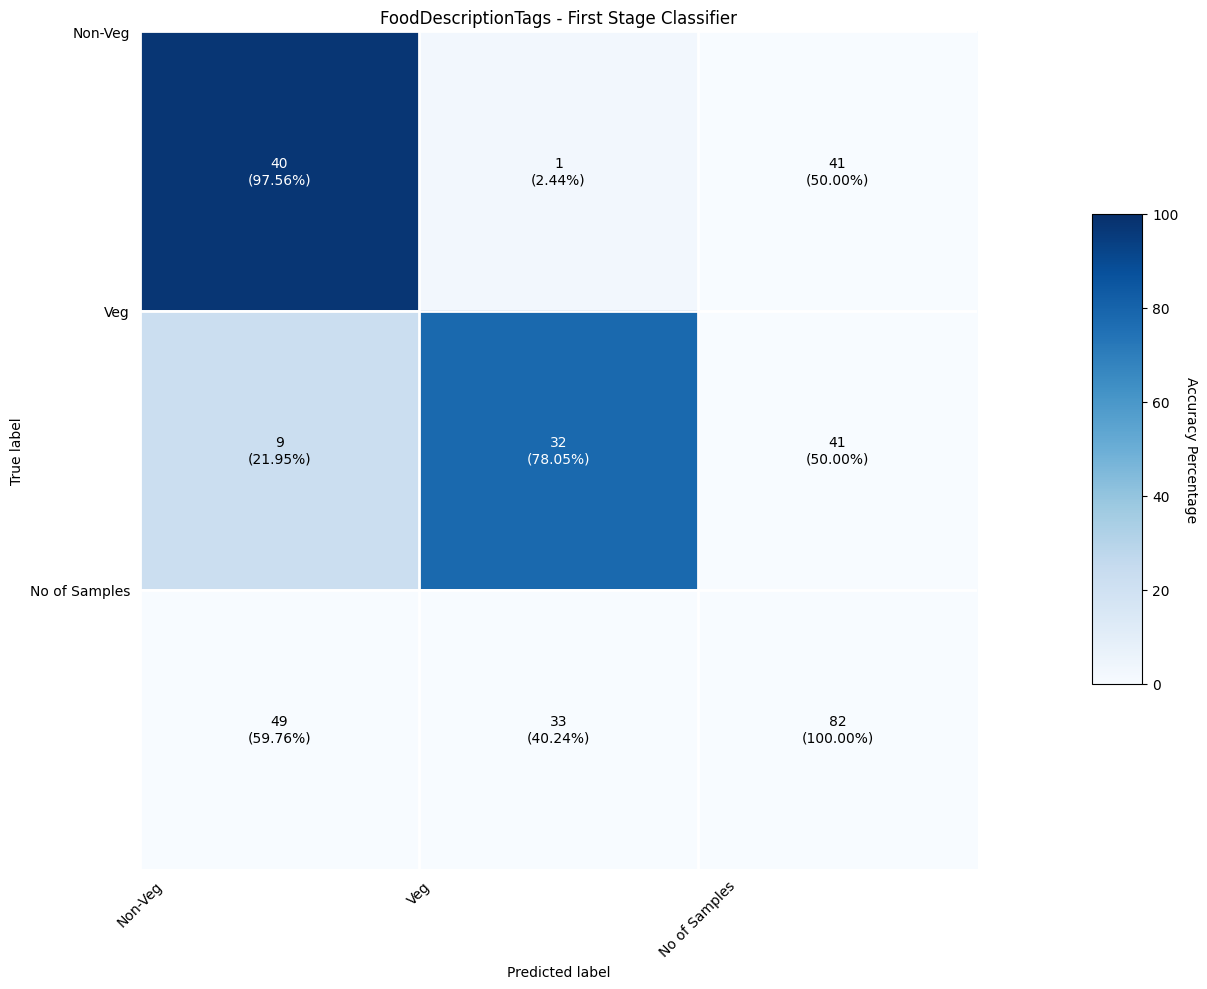

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Sample data
y_true = pdf.y_true.to_list()
y_pred = pdf.y_pred.to_list()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = np.unique(y_true)
n_classes = len(classes)

# Compute accuracy percentages for each class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create the expanded confusion matrix with sum rows and columns
cm_perc = np.zeros((n_classes+1, n_classes+1), dtype=float)
cm_perc[:n_classes, :n_classes] = cm_normalized

# Compute the sum values for the last row/column
cm_with_sum = np.vstack([cm, cm.sum(axis=0)])
cm_with_sum = np.hstack([cm_with_sum, cm_with_sum.sum(axis=1)[:, np.newaxis]])

total_predictions = cm.sum()

fig, ax = plt.subplots(figsize=(10,10))

# Use cm_perc for shading
im = ax.imshow(cm_perc, interpolation='nearest', cmap="Blues", vmin=0, vmax=100)

# Color bar settings
left = ax.get_position().x1 + 0.2
bottom = ax.get_position().y0 +0.2
width = 0.05
height = ax.get_position().height -0.3
cbar_ax = fig.add_axes([left, bottom, width, height])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('Accuracy Percentage', rotation=270, va='bottom')

# Ticks, grid and gridlines
ax.set(xticks=np.arange(cm_perc.shape[1])-0.5, 
       yticks=np.arange(cm_perc.shape[0])-0.5, 
       xticklabels=list(classes)+['Sum'], yticklabels=list(classes)+['No of Samples'],
       ylabel='True label',
       xlabel='Predicted label',
       title='FoodDescriptionTags - First Stage Classifier')

# Rotate xticks
ax.set_xticklabels(list(classes)+['No of Samples'], rotation=45)

# Creating a white grid to separate each cell
ax.set_xticks(np.arange(cm_perc.shape[1]), minor=True)
ax.set_yticks(np.arange(cm_perc.shape[0]), minor=True)
ax.grid(which='major', color='w', linestyle='-', linewidth=2)

# Text annotations
thresh = cm_perc.max() / 2.
for i in range(cm_perc.shape[0]):
    for j in range(cm_perc.shape[1]):
        if i < n_classes and j < n_classes:
            text = f"{cm[i, j]}\n({cm_normalized[i, j]:.2f}%)"
        elif i == n_classes or j == n_classes:  # Sum row/column
            percent = cm_with_sum[i, j] / total_predictions * 100
            text = f"{cm_with_sum[i, j]}\n({percent:.2f}%)"
        ax.text(j, i, text, ha="center", va="center", color="white" if cm_perc[i, j] > thresh else "black", fontsize=10)

# Remove spines and adjust ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=False, right=False)

plt.tight_layout()
plt.show()

In [47]:
pdf

,Description,y_true,y_true_id,pred,y_pred,pred_score,y_pred_id
0,"Chicken Parmesan, also known as Chicken Parmig...",Non-Veg,1,"[{'label': 'Non-Veg', 'score': 0.7973923087120...",Non-Veg,0.797392,1
1,"Zucchini Noodles, also known as zoodles, are a...",Veg,0,"[{'label': 'Non-Veg', 'score': 0.6548706889152...",Non-Veg,0.654871,1
2,Gnocchi are Italian dumplings made from potato...,Veg,0,"[{'label': 'Veg', 'score': 0.5741511583328247}]",Veg,0.574151,0
3,Roast Pork Bun is a popular Chinese dim sum di...,Non-Veg,1,"[{'label': 'Non-Veg', 'score': 0.7871509790420...",Non-Veg,0.787151,1
4,Banana Halwa is a traditional Indian dessert m...,Veg,0,"[{'label': 'Veg', 'score': 0.7921326756477356}]",Veg,0.792133,0
...,...,...,...,...,...,...,...
77,Jerk Chicken is a traditional Jamaican dish wi...,Non-Veg,1,"[{'label': 'Non-Veg', 'score': 0.8360526561737...",Non-Veg,0.836053,1
78,Urad Dal is a popular Indian dish made with bl...,Veg,0,"[{'label': 'Veg', 'score': 0.789516031742096}]",Veg,0.789516,0
79,Sticky Rice in Lotus Leaf is a traditional Chi...,Non-Veg,1,"[{'label': 'Non-Veg', 'score': 0.8386471867561...",Non-Veg,0.838647,1
80,Nougat is a chewy confection made with a mix o...,Non-Veg,1,"[{'label': 'Non-Veg', 'score': 0.6075856089591...",Non-Veg,0.607586,1


In [48]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

# Sample data
y_true = pdf.y_true_id.to_list()
y_pred = pdf.y_pred_id.to_list()

acc=accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred)
recall=recall_score(y_true,y_pred)
f1score=f1_score(y_true,y_pred)

print("\nAccuracy: ",acc,"\nPrecision: ",precision,"\nRecall: ",recall,"\nf1_score: ",f1score)


Accuracy:  0.8780487804878049 
Precision:  0.8163265306122449 
Recall:  0.975609756097561 
f1_score:  0.888888888888889


####  Improve quality of descriptions by including info about list of main dishes and cooking method. 

In [49]:
import random
def get_combined_desc_info(desc,ing,method):
    
    ing_opt=['The main ingredients used in this dish include ','For this dish, the main ingredients consist of ', 'The key components of this dish are ']
    method_opt=['The cooking method involves ','This dish is complemented by the cooking technique of ',]

    i=random.choice(ing_opt)
    m=random.choice(method_opt)

    if random.random()<0.5:
        return desc+' '+i+', '.join(ing)+'. '+m+method+'.'
    else:
        return desc+' '+m+method+'. '+i+', '.join(ing)+'.'

In [50]:
get_combined_desc_info(df.loc[0,'Description'],df.loc[0,'Ingredients'],df.loc[0,'CookingMethod'])

'Ven Pongal is a traditional South Indian breakfast dish made with rice and lentils, subtly spiced with cumin seeds, black pepper, and ginger, and cooked to a creamy consistency with ghee. It is a comforting and wholesome meal often served with coconut chutney and sambar. The key components of this dish are Rice, Lentils, Ghee, Cumin seeds, Black pepper, Ginger. The cooking method involves Boiling and tempering.'

In [51]:
combined_desc_info=[]

for i in range(len(df)):
    combined_desc_info.append(get_combined_desc_info(df.loc[i,'Description'],df.loc[i,'Ingredients'],df.loc[i,'CookingMethod']))

df['NewDesc']=combined_desc_info

In [52]:
df.loc[1,'NewDesc']

'Tom Yum Soup is a bold and aromatic Thai soup with a spicy, sour, and tangy flavor profile. It is loaded with fragrant herbs, succulent shrimp, mushrooms, and a hint of citrus from lime juice. This soup is known for its refreshing and invigorating taste. The cooking method involves Boiling. The key components of this dish are lemongrass, galangal, kaffir lime leaves, chili peppers, shrimp, mushrooms, lime juice.'

In [53]:
df.to_csv('updated_data.csv')

In [54]:
bert_model_diet='new_distilbert_clf_dietary/results/checkpoint-'+str(best_version)+'/'
with open('models.txt','a') as f:
    f.write('bert_model_diet,'+bert_model_diet)

### Training BERT Sequence classification models for other tags using combined description information.

In [55]:
base_model='new_distilbert_clf_dietary/results/checkpoint-'+str(best_version)+'/'

### Dietary Preference classification with improved data

In [62]:
utterances = df['NewDesc'].to_list()
seq_labels = df["DietaryPreference"].to_list()
print(len(utterances), len(seq_labels))


409 409


In [64]:
unique_seq_labels = list(df["DietaryPreference"].unique())
print(unique_seq_labels)

['Veg', 'Non-Veg']


In [65]:
seq_id = [unique_seq_labels.index(l) for l in seq_labels]

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
tokenized_utterances = []
attention_masks = []
for utt in tqdm(utterances) :
    try :
        it = tokenizer(utt, truncation=True, max_length=32)
        tokenized_utterances.append(it['input_ids'])
        attention_masks.append(it['attention_mask'])
    except :
        print(utt)
myData = Dataset.from_dict(dict(utterance=utterances,
                                input_ids=tokenized_utterances,
                                attention_mask=attention_masks,
                                label_txt=seq_labels,
                                label=seq_id)
                          )
# column we want to stratify with respect to
stratify_column_name = "label"

# create class label column and stratify
myData= myData.class_encode_column(stratify_column_name).train_test_split(test_size=0.2, stratify_by_column=stratify_column_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize the model using from_pretrained
seq_clf_mdl = DistilBertForSequenceClassification.from_pretrained(base_model)
seq_clf_mdl.config.id2label = {i: l for i, l in enumerate(unique_seq_labels)}

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

epochs = 30

training_args = TrainingArguments(
    output_dir="./distilbert_clf_dietary_new_data/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=1024,
    per_device_eval_batch_size=1024,
    load_best_model_at_end=True,
    logging_steps=1,
    log_level='info',
    evaluation_strategy='epoch',
    eval_steps=5000,
    save_strategy='epoch',
)

# Define the trainer:
trainer = Trainer(
    model=seq_clf_mdl,
    args=training_args,
    train_dataset=myData['train'],
    eval_dataset=myData['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

trainer.evaluate()

loading file vocab.txt from cache at /Users/anu/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/0dacbb01d604f8adeeb5b87c9339e485ac40d5c0/vocab.txt
loading file tokenizer.json from cache at /Users/anu/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/0dacbb01d604f8adeeb5b87c9339e485ac40d5c0/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/anu/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/0dacbb01d604f8adeeb5b87c9339e485ac40d5c0/tokenizer_config.json
loading configuration file config.json from cache at /Users/anu/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/0dacbb01d604f8adeeb5b87c9339e485ac40d5c0/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768

  0%|          | 0/409 [00:00<?, ?it/s]

Stringifying the column:   0%|          | 0/409 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/409 [00:00<?, ? examples/s]

loading configuration file new_distilbert_clf_dietary/results/checkpoint-11/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Veg",
    "1": "Non-Veg"
  },
  "initializer_range": 0.02,
  "label2id": null,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.38.2",
  "vocab_size": 30522
}

loading weights file new_distilbert_clf_dietary/results/checkpoint-11/model.safetensors
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.4363369345664978,
 'eval_accuracy': 0.8048780487804879,
 'eval_runtime': 0.13,
 'eval_samples_per_second': 630.536,
 'eval_steps_per_second': 7.689}

In [66]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 327
  Num Epochs = 30
  Instantaneous batch size per device = 1,024
  Total train batch size (w. parallel, distributed & accumulation) = 1,024
  Gradient Accumulation steps = 1
  Total optimization steps = 30
  Number of trainable parameters = 66,955,010


  0%|          | 0/30 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.393, 'grad_norm': 1.3164680004119873, 'learning_rate': 4.8333333333333334e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-1
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-1/config.json


{'eval_loss': 0.770361065864563, 'eval_accuracy': 0.5975609756097561, 'eval_runtime': 0.1905, 'eval_samples_per_second': 430.455, 'eval_steps_per_second': 5.249, 'epoch': 1.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-1/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.8408, 'grad_norm': 14.093220710754395, 'learning_rate': 4.666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-2
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-2/config.json


{'eval_loss': 0.43920135498046875, 'eval_accuracy': 0.8414634146341463, 'eval_runtime': 0.1042, 'eval_samples_per_second': 786.623, 'eval_steps_per_second': 9.593, 'epoch': 2.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-2/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.4613, 'grad_norm': 11.002134323120117, 'learning_rate': 4.5e-05, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-3
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-3/config.json


{'eval_loss': 0.5334891080856323, 'eval_accuracy': 0.7195121951219512, 'eval_runtime': 0.1288, 'eval_samples_per_second': 636.701, 'eval_steps_per_second': 7.765, 'epoch': 3.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-3/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.5199, 'grad_norm': 16.494909286499023, 'learning_rate': 4.3333333333333334e-05, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-4
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-4/config.json


{'eval_loss': 0.549421489238739, 'eval_accuracy': 0.7317073170731707, 'eval_runtime': 0.1142, 'eval_samples_per_second': 718.177, 'eval_steps_per_second': 8.758, 'epoch': 4.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-4/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.5429, 'grad_norm': 15.943553924560547, 'learning_rate': 4.166666666666667e-05, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-5
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-5/config.json


{'eval_loss': 0.3928678631782532, 'eval_accuracy': 0.8536585365853658, 'eval_runtime': 0.1034, 'eval_samples_per_second': 792.828, 'eval_steps_per_second': 9.669, 'epoch': 5.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-5/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.3894, 'grad_norm': 3.901588201522827, 'learning_rate': 4e-05, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-6
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-6/config.json


{'eval_loss': 0.42682313919067383, 'eval_accuracy': 0.8414634146341463, 'eval_runtime': 0.1001, 'eval_samples_per_second': 819.007, 'eval_steps_per_second': 9.988, 'epoch': 6.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-6/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.4138, 'grad_norm': 6.188758850097656, 'learning_rate': 3.8333333333333334e-05, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-7
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-7/config.json


{'eval_loss': 0.4308886229991913, 'eval_accuracy': 0.8414634146341463, 'eval_runtime': 0.1054, 'eval_samples_per_second': 778.194, 'eval_steps_per_second': 9.49, 'epoch': 7.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-7/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.4153, 'grad_norm': 6.921964168548584, 'learning_rate': 3.6666666666666666e-05, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-8
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-8/config.json


{'eval_loss': 0.376510888338089, 'eval_accuracy': 0.8414634146341463, 'eval_runtime': 0.1072, 'eval_samples_per_second': 764.783, 'eval_steps_per_second': 9.327, 'epoch': 8.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-8/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.341, 'grad_norm': 5.110960960388184, 'learning_rate': 3.5e-05, 'epoch': 9.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-9
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-9/config.json


{'eval_loss': 0.31996771693229675, 'eval_accuracy': 0.8780487804878049, 'eval_runtime': 0.1121, 'eval_samples_per_second': 731.62, 'eval_steps_per_second': 8.922, 'epoch': 9.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-9/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.2647, 'grad_norm': 1.631649136543274, 'learning_rate': 3.3333333333333335e-05, 'epoch': 10.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-10
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-10/config.json


{'eval_loss': 0.3311857581138611, 'eval_accuracy': 0.8658536585365854, 'eval_runtime': 0.1051, 'eval_samples_per_second': 780.449, 'eval_steps_per_second': 9.518, 'epoch': 10.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-10/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.2571, 'grad_norm': 4.69238805770874, 'learning_rate': 3.1666666666666666e-05, 'epoch': 11.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-11
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-11/config.json


{'eval_loss': 0.32779863476753235, 'eval_accuracy': 0.8658536585365854, 'eval_runtime': 0.1041, 'eval_samples_per_second': 788.06, 'eval_steps_per_second': 9.61, 'epoch': 11.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-11/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.2225, 'grad_norm': 4.085119724273682, 'learning_rate': 3e-05, 'epoch': 12.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-12
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-12/config.json


{'eval_loss': 0.2916436195373535, 'eval_accuracy': 0.8780487804878049, 'eval_runtime': 0.1079, 'eval_samples_per_second': 759.927, 'eval_steps_per_second': 9.267, 'epoch': 12.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-12/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1878, 'grad_norm': 1.626528024673462, 'learning_rate': 2.8333333333333335e-05, 'epoch': 13.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-13
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-13/config.json


{'eval_loss': 0.3084199130535126, 'eval_accuracy': 0.8902439024390244, 'eval_runtime': 0.1056, 'eval_samples_per_second': 776.59, 'eval_steps_per_second': 9.471, 'epoch': 13.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-13/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1787, 'grad_norm': 5.096836090087891, 'learning_rate': 2.6666666666666667e-05, 'epoch': 14.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-14
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-14/config.json


{'eval_loss': 0.32042548060417175, 'eval_accuracy': 0.8780487804878049, 'eval_runtime': 0.1082, 'eval_samples_per_second': 757.673, 'eval_steps_per_second': 9.24, 'epoch': 14.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-14/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1952, 'grad_norm': 7.075080871582031, 'learning_rate': 2.5e-05, 'epoch': 15.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-15
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-15/config.json


{'eval_loss': 0.2928704619407654, 'eval_accuracy': 0.8902439024390244, 'eval_runtime': 0.1081, 'eval_samples_per_second': 758.74, 'eval_steps_per_second': 9.253, 'epoch': 15.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-15/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1526, 'grad_norm': 3.8979454040527344, 'learning_rate': 2.3333333333333336e-05, 'epoch': 16.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-16
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-16/config.json


{'eval_loss': 0.2621161639690399, 'eval_accuracy': 0.9146341463414634, 'eval_runtime': 0.1073, 'eval_samples_per_second': 764.007, 'eval_steps_per_second': 9.317, 'epoch': 16.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-16/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1307, 'grad_norm': 1.2003003358840942, 'learning_rate': 2.1666666666666667e-05, 'epoch': 17.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-17
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-17/config.json


{'eval_loss': 0.265697717666626, 'eval_accuracy': 0.8780487804878049, 'eval_runtime': 0.0985, 'eval_samples_per_second': 832.149, 'eval_steps_per_second': 10.148, 'epoch': 17.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-17/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1327, 'grad_norm': 2.8247456550598145, 'learning_rate': 2e-05, 'epoch': 18.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-18
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-18/config.json


{'eval_loss': 0.2640610337257385, 'eval_accuracy': 0.8902439024390244, 'eval_runtime': 0.1091, 'eval_samples_per_second': 751.308, 'eval_steps_per_second': 9.162, 'epoch': 18.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-18/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1217, 'grad_norm': 3.0747203826904297, 'learning_rate': 1.8333333333333333e-05, 'epoch': 19.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-19
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-19/config.json


{'eval_loss': 0.26180559396743774, 'eval_accuracy': 0.9146341463414634, 'eval_runtime': 0.1064, 'eval_samples_per_second': 770.554, 'eval_steps_per_second': 9.397, 'epoch': 19.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-19/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1088, 'grad_norm': 1.4896740913391113, 'learning_rate': 1.6666666666666667e-05, 'epoch': 20.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-20
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-20/config.json


{'eval_loss': 0.2882869839668274, 'eval_accuracy': 0.9146341463414634, 'eval_runtime': 0.1068, 'eval_samples_per_second': 767.517, 'eval_steps_per_second': 9.36, 'epoch': 20.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-20/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.1076, 'grad_norm': 3.2049973011016846, 'learning_rate': 1.5e-05, 'epoch': 21.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-21
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-21/config.json


{'eval_loss': 0.30504536628723145, 'eval_accuracy': 0.9024390243902439, 'eval_runtime': 0.105, 'eval_samples_per_second': 780.617, 'eval_steps_per_second': 9.52, 'epoch': 21.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-21/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.0912, 'grad_norm': 3.025430917739868, 'learning_rate': 1.3333333333333333e-05, 'epoch': 22.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-22
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-22/config.json


{'eval_loss': 0.2994687259197235, 'eval_accuracy': 0.8902439024390244, 'eval_runtime': 0.1, 'eval_samples_per_second': 819.936, 'eval_steps_per_second': 9.999, 'epoch': 22.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-22/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.0843, 'grad_norm': 1.8391567468643188, 'learning_rate': 1.1666666666666668e-05, 'epoch': 23.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-23
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-23/config.json


{'eval_loss': 0.28200048208236694, 'eval_accuracy': 0.9024390243902439, 'eval_runtime': 0.1048, 'eval_samples_per_second': 782.653, 'eval_steps_per_second': 9.545, 'epoch': 23.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-23/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.0792, 'grad_norm': 1.7301015853881836, 'learning_rate': 1e-05, 'epoch': 24.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-24
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-24/config.json


{'eval_loss': 0.27078598737716675, 'eval_accuracy': 0.9146341463414634, 'eval_runtime': 0.0994, 'eval_samples_per_second': 825.032, 'eval_steps_per_second': 10.061, 'epoch': 24.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-24/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.0639, 'grad_norm': 0.7805399894714355, 'learning_rate': 8.333333333333334e-06, 'epoch': 25.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-25
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-25/config.json


{'eval_loss': 0.2752014100551605, 'eval_accuracy': 0.9024390243902439, 'eval_runtime': 0.1033, 'eval_samples_per_second': 793.567, 'eval_steps_per_second': 9.678, 'epoch': 25.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-25/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.0749, 'grad_norm': 2.186218738555908, 'learning_rate': 6.666666666666667e-06, 'epoch': 26.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-26
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-26/config.json


{'eval_loss': 0.28000378608703613, 'eval_accuracy': 0.9024390243902439, 'eval_runtime': 0.0993, 'eval_samples_per_second': 825.581, 'eval_steps_per_second': 10.068, 'epoch': 26.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-26/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.0914, 'grad_norm': 4.3136162757873535, 'learning_rate': 5e-06, 'epoch': 27.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-27
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-27/config.json


{'eval_loss': 0.2806924879550934, 'eval_accuracy': 0.9024390243902439, 'eval_runtime': 0.1002, 'eval_samples_per_second': 818.699, 'eval_steps_per_second': 9.984, 'epoch': 27.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-27/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.0637, 'grad_norm': 1.687484860420227, 'learning_rate': 3.3333333333333333e-06, 'epoch': 28.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-28
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-28/config.json


{'eval_loss': 0.2804952561855316, 'eval_accuracy': 0.9024390243902439, 'eval_runtime': 0.1029, 'eval_samples_per_second': 796.944, 'eval_steps_per_second': 9.719, 'epoch': 28.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-28/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.067, 'grad_norm': 1.687299132347107, 'learning_rate': 1.6666666666666667e-06, 'epoch': 29.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-29
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-29/config.json


{'eval_loss': 0.280972421169281, 'eval_accuracy': 0.9146341463414634, 'eval_runtime': 0.0998, 'eval_samples_per_second': 821.998, 'eval_steps_per_second': 10.024, 'epoch': 29.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-29/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


{'loss': 0.0637, 'grad_norm': 1.0627294778823853, 'learning_rate': 0.0, 'epoch': 30.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-30
Configuration saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-30/config.json


{'eval_loss': 0.2817882299423218, 'eval_accuracy': 0.9146341463414634, 'eval_runtime': 0.1056, 'eval_samples_per_second': 776.521, 'eval_steps_per_second': 9.47, 'epoch': 30.0}


Model weights saved in ./distilbert_clf_dietary_new_data/results/tmp-checkpoint-30/model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./distilbert_clf_dietary_new_data/results/checkpoint-19 (score: 0.26180559396743774).


{'train_runtime': 85.9399, 'train_samples_per_second': 114.149, 'train_steps_per_second': 0.349, 'train_loss': 0.2352274959286054, 'epoch': 30.0}


TrainOutput(global_step=30, training_loss=0.2352274959286054, metrics={'train_runtime': 85.9399, 'train_samples_per_second': 114.149, 'train_steps_per_second': 0.349, 'train_loss': 0.2352274959286054, 'epoch': 30.0})

In [67]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: utterance, label_txt. If utterance, label_txt are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 1024


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.26180559396743774,
 'eval_accuracy': 0.9146341463414634,
 'eval_runtime': 0.2586,
 'eval_samples_per_second': 317.127,
 'eval_steps_per_second': 3.867,
 'epoch': 30.0}

In [68]:
trainer.save_model()

Saving model checkpoint to ./distilbert_clf_dietary_new_data/results
Configuration saved in ./distilbert_clf_dietary_new_data/results/config.json
Model weights saved in ./distilbert_clf_dietary_new_data/results/model.safetensors


In [69]:
pipe = pipeline("text-classification", seq_clf_mdl, tokenizer=tokenizer)
pipe("Chicken 65 is a popular Indian dish known for its distinct flavor and unique preparation method. Originating from Chennai, this spicy and deep-fried chicken dish is a favorite among food enthusiasts. The dish gets its intriguing name from the year it was introduced at the famous Buhari Hotel in Chennai. The exact recipe for Chicken 65 can vary depending on the region and the chef, but typically involves marinating bite-sized chicken pieces in a blend of spices, including red chili powder, turmeric, ginger, garlic, and curry leaves. The marinated chicken is then deep-fried to achieve a crispy texture on the outside while remaining tender and juicy on the inside. Some variations of Chicken 65 may include the addition of yogurt or vinegar to enhance the tangy flavor. Once fried to perfection, the chicken is often garnished with fresh cilantro, onion slices, and lemon wedges before serving. The combination of spicy, tangy, and flavorful elements makes Chicken 65 a beloved dish that is commonly enjoyed as a starter or appetizer. It pairs well with refreshing beverages like lemonade or a cold beer. Whether served at a casual gathering or a festive celebration, Chicken 65 never fails to impress with its bold flavors and tantalizing aroma. Despite its fiery reputation, this dish continues to captivate food lovers with its perfect balance of heat and taste. Chicken 65 has even inspired variations such as paneer 65 for vegetarians, further cementing its legacy as a must-try dish in Indian cuisine.")

[{'label': 'Non-Veg', 'score': 0.9453746676445007}]

In [71]:
pred_df = pd.DataFrame(myData['test'], columns=['utterance', 'input_ids', 'attention_mask', 'label_txt', 'label'])
pred_df.drop(columns=['input_ids', 'attention_mask'], inplace=True)
pred_df.shape

(82, 3)

In [72]:
from sklearn.metrics import f1_score

new_f1_scores=[]

for i in tqdm(range(1,31)):
    pdf = pred_df[['utterance', 'label_txt', 'label']
                ].rename(columns={'utterance': 'Description', 'label_txt': 'y_true', 'label': 'y_true_id'})

    pipe = pipeline("text-classification", DistilBertForSequenceClassification.from_pretrained('./distilbert_clf_dietary_new_data/results/checkpoint-'+str(i)+'/'), tokenizer=tokenizer)
    pdf["pred"] = pdf.Description.apply(lambda x: pipe(x))

    pdf["pred_label"] = pdf.pred.apply(lambda x: x[0]['label'])
    pdf["pred_score"] = pdf.pred.apply(lambda x: x[0]['score'])

    pdf.rename(columns={'pred_label': 'y_pred'}, inplace=True)
    pdf["y_pred_id"] = pdf.y_pred.apply(lambda x: unique_seq_labels.index(x))


    new_f1_scores.append(f1_score(pdf['y_true_id'],pdf['y_pred_id']))

  0%|          | 0/30 [00:00<?, ?it/s]

loading configuration file ./distilbert_clf_dietary_new_data/results/checkpoint-1/config.json
Model config DistilBertConfig {
  "_name_or_path": "new_distilbert_clf_dietary/results/checkpoint-11/",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Veg",
    "1": "Non-Veg"
  },
  "initializer_range": 0.02,
  "label2id": null,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.38.2",
  "vocab_size": 30522
}

loading weights file ./distilbert_clf_dietary_new_data/results/checkpoint-1/model.safetensors
All model checkpoint weights were used when initializing DistilB

In [73]:
f1_scores

[0.09302325581395349,
 0.689075630252101,
 0.6451612903225806,
 0.5614035087719299,
 0.7522935779816513,
 0.8421052631578947,
 0.7428571428571429,
 0.7733333333333334,
 0.8723404255319149,
 0.8039215686274509,
 0.888888888888889,
 0.888888888888889,
 0.860215053763441,
 0.851063829787234,
 0.8453608247422679,
 0.8571428571428571,
 0.8421052631578947,
 0.8247422680412371,
 0.8421052631578947,
 0.8333333333333334,
 0.8163265306122448,
 0.8421052631578947,
 0.8695652173913043,
 0.8695652173913043,
 0.860215053763441,
 0.8421052631578947,
 0.8333333333333334,
 0.8333333333333334,
 0.8421052631578947,
 0.8421052631578947]

In [81]:
best_version=np.array(new_f1_scores).argmax()+1
best_version

4

In [82]:
pdf = pred_df[['utterance', 'label_txt', 'label']
             ].rename(columns={'utterance': 'Description', 'label_txt': 'y_true', 'label': 'y_true_id'})


pipe = pipeline("text-classification", DistilBertForSequenceClassification.from_pretrained('new_distilbert_clf_dietary/results/checkpoint-'+str(best_version)+'/'), tokenizer=tokenizer)
pdf["pred"] = pdf.Description.apply(lambda x: pipe(x))

loading configuration file new_distilbert_clf_dietary/results/checkpoint-4/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Veg",
    "1": "Non-Veg"
  },
  "initializer_range": 0.02,
  "label2id": null,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.38.2",
  "vocab_size": 30522
}

loading weights file new_distilbert_clf_dietary/results/checkpoint-4/model.safetensors
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the w

In [83]:
pdf["pred_label"] = pdf.pred.apply(lambda x: x[0]['label'])
pdf["pred_score"] = pdf.pred.apply(lambda x: x[0]['score'])

In [84]:
pdf.rename(columns={'pred_label': 'y_pred'}, inplace=True)
pdf["y_pred_id"] = pdf.y_pred.apply(lambda x: unique_seq_labels.index(x))

/var/folders/2p/d_5l4xlj7ygbv8ldw505sjnr0000gn/T/ipykernel_10422/2770615981.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


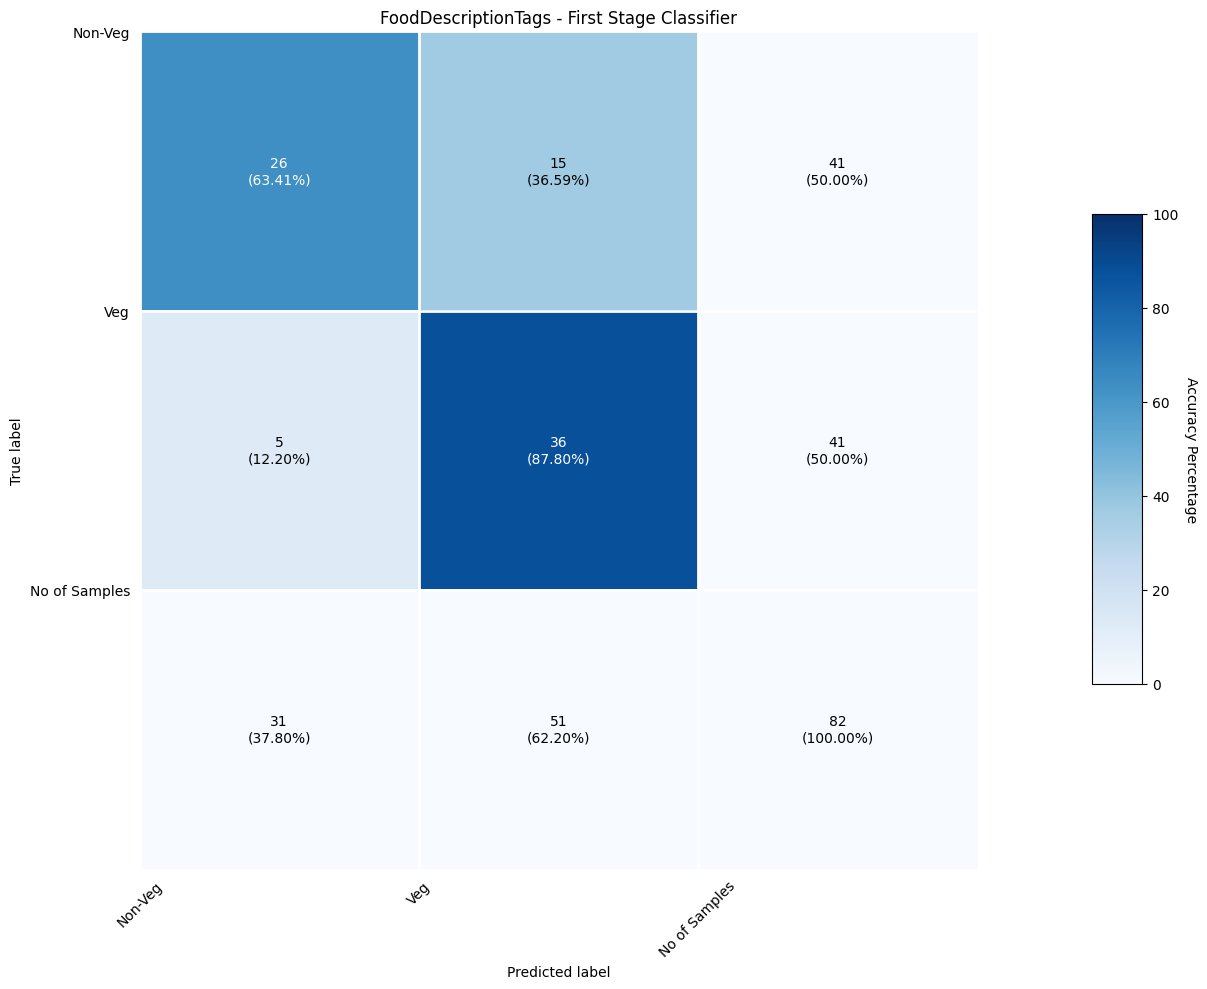

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Sample data
y_true = pdf.y_true.to_list()
y_pred = pdf.y_pred.to_list()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = np.unique(y_true)
n_classes = len(classes)

# Compute accuracy percentages for each class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create the expanded confusion matrix with sum rows and columns
cm_perc = np.zeros((n_classes+1, n_classes+1), dtype=float)
cm_perc[:n_classes, :n_classes] = cm_normalized

# Compute the sum values for the last row/column
cm_with_sum = np.vstack([cm, cm.sum(axis=0)])
cm_with_sum = np.hstack([cm_with_sum, cm_with_sum.sum(axis=1)[:, np.newaxis]])

total_predictions = cm.sum()

fig, ax = plt.subplots(figsize=(10,10))

# Use cm_perc for shading
im = ax.imshow(cm_perc, interpolation='nearest', cmap="Blues", vmin=0, vmax=100)

# Color bar settings
left = ax.get_position().x1 + 0.2
bottom = ax.get_position().y0 +0.2
width = 0.05
height = ax.get_position().height -0.3
cbar_ax = fig.add_axes([left, bottom, width, height])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('Accuracy Percentage', rotation=270, va='bottom')

# Ticks, grid and gridlines
ax.set(xticks=np.arange(cm_perc.shape[1])-0.5, 
       yticks=np.arange(cm_perc.shape[0])-0.5, 
       xticklabels=list(classes)+['Sum'], yticklabels=list(classes)+['No of Samples'],
       ylabel='True label',
       xlabel='Predicted label',
       title='FoodDescriptionTags - First Stage Classifier')

# Rotate xticks
ax.set_xticklabels(list(classes)+['No of Samples'], rotation=45)

# Creating a white grid to separate each cell
ax.set_xticks(np.arange(cm_perc.shape[1]), minor=True)
ax.set_yticks(np.arange(cm_perc.shape[0]), minor=True)
ax.grid(which='major', color='w', linestyle='-', linewidth=2)

# Text annotations
thresh = cm_perc.max() / 2.
for i in range(cm_perc.shape[0]):
    for j in range(cm_perc.shape[1]):
        if i < n_classes and j < n_classes:
            text = f"{cm[i, j]}\n({cm_normalized[i, j]:.2f}%)"
        elif i == n_classes or j == n_classes:  # Sum row/column
            percent = cm_with_sum[i, j] / total_predictions * 100
            text = f"{cm_with_sum[i, j]}\n({percent:.2f}%)"
        ax.text(j, i, text, ha="center", va="center", color="white" if cm_perc[i, j] > thresh else "black", fontsize=10)

# Remove spines and adjust ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=False, right=False)

plt.tight_layout()
plt.show()

In [86]:
pdf

,Description,y_true,y_true_id,pred,y_pred,pred_score,y_pred_id
0,Tortellini in Brodo is a classic Italian dish ...,Non-Veg,1,"[{'label': 'Non-Veg', 'score': 0.5672301650047...",Non-Veg,0.567230,1
1,Prosciutto is a dry-cured ham that is thinly s...,Non-Veg,1,"[{'label': 'Veg', 'score': 0.5460101366043091}]",Veg,0.546010,0
2,Goan Prawn Curry is a flavorful seafood dish f...,Non-Veg,1,"[{'label': 'Non-Veg', 'score': 0.5356796383857...",Non-Veg,0.535680,1
3,Honey Walnut Shrimp is a popular Chinese-Ameri...,Non-Veg,1,"[{'label': 'Non-Veg', 'score': 0.5318763256072...",Non-Veg,0.531876,1
4,Soy Sauce Chicken is a classic Chinese dish wh...,Non-Veg,1,"[{'label': 'Non-Veg', 'score': 0.5061180591583...",Non-Veg,0.506118,1
...,...,...,...,...,...,...,...
77,Methi Thepla is a popular flatbread from the s...,Veg,0,"[{'label': 'Veg', 'score': 0.5764021873474121}]",Veg,0.576402,0
78,Lamb Saag is a traditional South Asian dish ma...,Non-Veg,1,"[{'label': 'Non-Veg', 'score': 0.5131606459617...",Non-Veg,0.513161,1
79,Kongunadu Chicken Curry is a flavorful South I...,Non-Veg,1,"[{'label': 'Non-Veg', 'score': 0.5199657678604...",Non-Veg,0.519966,1
80,Osso Buco is a traditional Italian dish featur...,Non-Veg,1,"[{'label': 'Veg', 'score': 0.5065984129905701}]",Veg,0.506598,0


In [87]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

# Sample data
y_true = pdf.y_true_id.to_list()
y_pred = pdf.y_pred_id.to_list()

acc=accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred)
recall=recall_score(y_true,y_pred)
f1score=f1_score(y_true,y_pred)

print("\nAccuracy: ",acc,"\nPrecision: ",precision,"\nRecall: ",recall,"\nf1_score: ",f1score)


Accuracy:  0.7560975609756098 
Precision:  0.8387096774193549 
Recall:  0.6341463414634146 
f1_score:  0.7222222222222222


The previous classifier performs better